In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from scipy.stats import bootstrap, mannwhitneyu

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
data_path = "~/data/hatespeech/unfiltered_ratings.feather"
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"

In [4]:
data = pd.read_feather(data_path)

In [30]:
# Read in hate speech data
data = pd.read_feather(data_path)
# Remove all rows in which some item is missing
data = utils.filter_missing_items(data)
# Remove all rows in which the rater is not up to sufficient quality
rater_quality = pd.read_csv(rater_quality_path)
data = utils.filter_annotator_quality(data, rater_quality)
# Recode item responses
data = utils.recode_responses(
    data,
    insult={1: 0, 2: 1, 3: 2, 4: 3},
    humiliate={1: 0, 2: 0, 3: 1, 4: 2},
    status={1: 0, 2: 0, 3: 1, 4: 1},
    dehumanize={1: 0, 2: 0, 3: 1, 4: 1},
    violence={1: 0, 2: 0, 3: 1, 4: 1},
    genocide={1: 0, 2: 0, 3: 1, 4: 1},
    attack_defend={1: 0, 2: 1, 3: 2, 4: 3},
    hatespeech={1: 0, 2: 1})
# Maximum values for each survey item
norms = {
    'sentiment': 4,
    'respect': 4,
    'insult': 3,
    'humiliate': 2,
    'status': 1,
    'dehumanize': 1,
    'violence': 1,
    'genocide': 1,
    'attack_defend': 3,
    'hatespeech': 1
}
# Labels
labels = {
    'sentiment': 'Sentiment',
    'respect': 'Respect',
    'insult': 'Insult',
    'humiliate': 'Humiliate',
    'status': 'Status',
    'dehumanize': 'Dehumanize',
    'violence': 'Violence',
    'genocide': 'Genocide',
    'attack_defend': 'Attack/Defend',
    'hatespeech': 'Hate Speech'
}

In [22]:
# Extract reference set
reference_set = data[data['platform'] == 'reference'].copy()

In [23]:
print(f'Number of unique reference set comments: {reference_set["comment_id"].unique().size}')
print(f'Number of samples in reference set: {reference_set.shape[0]}')

Number of unique reference set comments: 70
Number of samples in reference set: 50211


In [13]:
# Black/white targeting comments by black/white annotators
bw_targets = ['target_race_black', 'target_race_white']
reference_bw = utils.filter_annotator_identity(reference_set, ['annotator_race_black', 'annotator_race_white'])
bw_agreement, reference_targeting_bw = utils.get_comments_w_agreement_on_target(
    data=reference_bw,
    targets=bw_targets,
    threshold=0.5,
    suffix='_label')
targeting_black = reference_targeting_bw[reference_targeting_bw['target_race_black_label']].copy()
# Add in annotator label
targeting_black['annotator_race'] = np.where(targeting_black['annotator_race_black'], 'black', 'white')
# Calculate differences along black/white annotators
bw_diffs = targeting_black.groupby(['comment_id', 'annotator_race']).mean()[keys.items]
bw_mean_diffs = bw_diffs.diff().query("annotator_race == 'white'").droplevel('annotator_race')

In [100]:
for item in keys.items:
    print(item, mannwhitneyu(black_ratings[item], white_ratings[item], alternative='greater').pvalue)

sentiment 0.07573385770407798
respect 0.04715095299285973
insult 0.0077241060367390915
humiliate 0.02935231423883827
status 0.8177309208263289
dehumanize 0.01028831902362266
violence 0.450985027771951
genocide 0.6695445592472813
attack_defend 0.017997039784163373
hatespeech 0.0009095525102722038


In [14]:
race_comment_id = 20032
race_comment = targeting_black[targeting_black['comment_id'] == race_comment_id]
print(f"Comment #{race_comment_id}:",
      race_comment.drop_duplicates('comment_id').raw_text.values[0])
black_ratings = race_comment[race_comment['annotator_race'] == 'black'][keys.items]
white_ratings = race_comment[race_comment['annotator_race'] == 'white'][keys.items]
mean_black_ratings = black_ratings.mean()
mean_white_ratings = white_ratings.mean()

Comment #20032: shut the fuck up you dumb black bitch


In [20]:
# Men/white targeting comments by black/white annotators
mw_targets = ['target_gender_women', 'target_gender_men']
reference_mw = utils.filter_annotator_identity(reference_set, ['annotator_gender_men', 'annotator_gender_women'])
bw_agreement, reference_targeting_mw = utils.get_comments_w_agreement_on_target(
    data=reference_mw,
    targets=mw_targets,
    threshold=0.5,
    suffix='_label')
targeting_women = reference_targeting_mw[reference_targeting_mw['target_gender_women_label']].copy()
# Add in annotator label
targeting_women['annotator_gender'] = np.where(targeting_women['annotator_gender_women'], 'woman', 'man')
# Calculate differences along black/white annotators
mw_diffs = targeting_women.groupby(['comment_id', 'annotator_gender']).mean()[keys.items]
mw_mean_diffs = mw_diffs.diff().query("annotator_gender == 'man'").droplevel('annotator_gender')

In [91]:
gender_comment_id = 20044
gender_comment = targeting_women[targeting_women['comment_id'] == gender_comment_id]
print(f"Comment #{gender_comment_id}:",
      gender_comment.drop_duplicates('comment_id').raw_text.values[0])
men_ratings = gender_comment[gender_comment['annotator_gender'] == 'man'][keys.items]
women_ratings = gender_comment[gender_comment['annotator_gender'] == 'woman'][keys.items]
mean_men_ratings = men_ratings.mean()
mean_women_ratings = women_ratings.mean()

Comment #20044: It's actually because men need to be funny to hook up with women. We train to be funny, whereas a lot of women comedians think people should laugh just because they are on stage and the audience should be supportive. If you aren't funny, we aren't going to laugh. I've heard great female comedians, but it's not hard to see why there are more male comedians. Girls don't need to be funny to have sex.


In [99]:
for item in keys.items:
    print(item, mannwhitneyu(men_ratings[item], women_ratings[item], alternative='less').pvalue)

sentiment 0.007731259338659917
respect 3.844485324173798e-05
insult 2.9759861620307502e-05
humiliate 0.016840332535011496
status 0.00014895111057683467
dehumanize 0.26216467779493835
violence 0.9493352904480591
genocide 0.5823215896172189
attack_defend 0.04641428602624122
hatespeech 0.7088807763984147


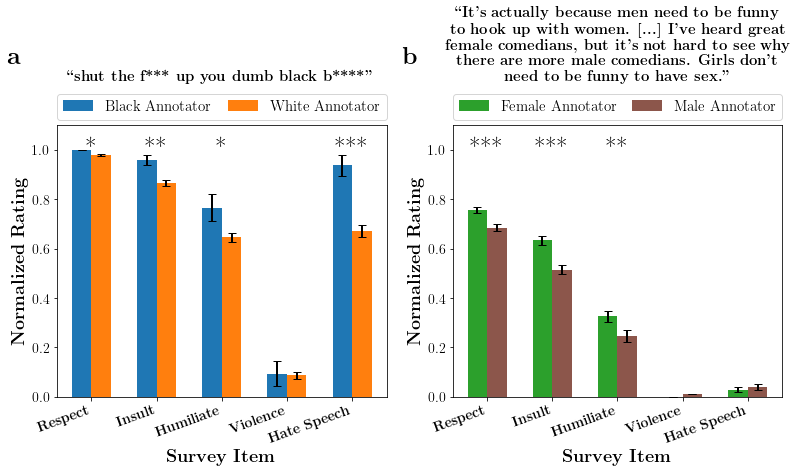

In [119]:
error_kw = {'capsize': 4,
            'lw': 2}
"""
Figure 1
"""
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

plot_items = ['respect', 'insult', 'humiliate', 'violence', 'hatespeech']
n_plot_items = len(plot_items)
plot_norms = [norms[item] for item in plot_items]
plot_labels = [labels[item] for item in plot_items]

black_errors = [bootstrap([black_ratings[item]], np.mean, method='basic').standard_error / norms[item]
                for item in plot_items]
white_errors = [bootstrap([white_ratings[item]], np.mean, method='basic').standard_error / norms[item]
                for item in plot_items]
women_errors = [bootstrap([women_ratings[item]], np.mean, method='basic').standard_error / norms[item]
                for item in plot_items]
men_errors = [bootstrap([women_ratings[item]], np.mean, method='basic').standard_error / norms[item]
              for item in plot_items]

width = 0.3
gap = 0.15
# Race plot
axes[0].bar(np.arange(5) - gap,
            mean_black_ratings[plot_items] / plot_norms,
            width=width,
            yerr=black_errors,
            label='Black Annotator',
            color='C0',
            error_kw=error_kw)
axes[0].bar(np.arange(5) + gap,
            mean_white_ratings[plot_items] / plot_norms,
            width=width,
            yerr=white_errors,
            label='White Annotator',
            color='C1',
            error_kw=error_kw)
axes[0].text(x=0, y=1.04,
             s='*',
             ha='center',
             va='center',
             fontsize=25)
axes[0].text(x=1, y=1.04,
             s='**',
             ha='center',
             va='center',
             fontsize=25)
axes[0].text(x=2, y=1.04,
             s='*',
             ha='center',
             va='center',
             fontsize=25)
axes[0].text(x=4, y=1.04,
             s='***',
             ha='center',
             va='center',
             fontsize=25)
             
# Gender plot
axes[1].bar(np.arange(5) - gap,
            mean_women_ratings[plot_items] / plot_norms,
            width=width,
            yerr=women_errors,
            label='Female Annotator',
            color='C2',
            error_kw=error_kw)
axes[1].bar(np.arange(5) + gap,
            mean_men_ratings[plot_items] / plot_norms,
            width=width,
            yerr=men_errors,
            label='Male Annotator',
            color='C5',
            error_kw=error_kw)

axes[1].text(x=0, y=1.04,
             s='***',
             ha='center',
             va='center',
             fontsize=25)
axes[1].text(x=1, y=1.04,
             s='***',
             ha='center',
             va='center',
             fontsize=25)
axes[1].text(x=2, y=1.04,
             s='**',
             ha='center',
             va='center',
             fontsize=25)


for ax in axes:
    ax.set_xticks(np.arange(n_plot_items))
    ax.set_xticklabels(mplego.labels.bold_text(plot_labels),
                       ha='right',
                       rotation=20)
    ax.tick_params(labelsize=14)
    ax.set_ylim([0, 1.1])
    ax.set_xlabel(mplego.labels.bold_text('Survey Item'), fontsize=18)
    ax.set_ylabel(mplego.labels.bold_text('Normalized Rating'), fontsize=18)
    ax.legend(bbox_to_anchor=(0., 1.02, 1, 0.2),
              loc="lower left",
              mode="expand",
              borderaxespad=0,
              prop={'size': 15},
              ncol=2)
    
axes[0].set_title(mplego.labels.bold_text("``shut the f*** up you dumb black b****''"),
                  pad=45,
                  fontsize=15)
axes[1].set_title(mplego.labels.bold_text("``It's actually because men need to be funny\n"
                                             "to hook up with women. [...] I've heard great\nfemale comedians, "
                                             "but it's not hard to see why\nthere are more male comedians. "
                                             "Girls don't\nneed to be funny to have sex.''"),
                  pad=45,
                  fontsize=15)

mplego.labels.apply_subplot_labels(axes, bold=True, size=25, x=-0.13, y=1.25)
plt.savefig('figure1.pdf', bbox_inches='tight')

In [82]:
gender_comment.raw_text.iloc[0]

'Men are still ten times more likely to die on the job. As we get more ""equality"", I don\'t see women taking dangerous jobs from men. Women are taking safe jobs from men so even more men will die on the job. If we were to have a another Vietnam (60,000 killed), 97% will be men. Men die earlier than women, but spending on woman\'s healthcare research (breast, ovarian cancer etc.) is four (4) times greater than the sending on mens healthcare research (prostate, testicular cancer etc.). The list goes on.'

In [114]:
#make the columns values (black, white) into columns
df_20001_race.T.columns

Index(['black', 'white'], dtype='object', name='race_label')

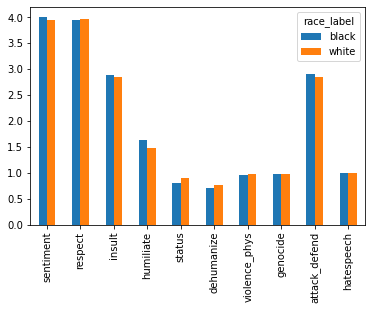

In [118]:
df_20001_race.T.plot.bar();

In [ ]:
#what's the comment_id that targets black folks and that has the most black labelers on it?
#this could help us decide which comments to see and also is interesting in and of itself
#for comments with greater than 50 labelers, what does the distribution of black labelers

In [124]:
#okay so here's a function that does everything we just did and puts into one 

def mean_item_by_race(df, comment_id_no):
    """ comment_id_no is the comment id number
    df is the dataframe"""
    
    items = ['sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence_phys', 'genocide', 'attack_defend', 'hatespeech'] 
    
    df_comment = df[df['comment_id'] == comment_id_no]
    
    df_comment_race = df_comment[df_comment['race_label'].isin(['black', 'white'])].groupby(by=['race_label', 'comment_id']).mean()[items]
    
    df_comment_race.reset_index(level=['comment_id'], inplace=True)
    
    df_comment_race = df_comment_race.drop('comment_id', 1)
    
    return df_comment_race.T.plot.bar()

 

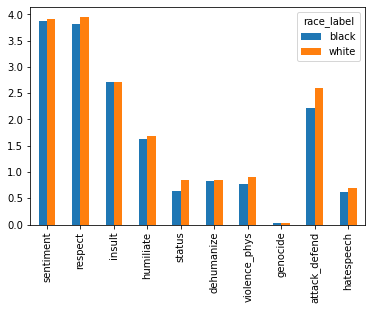

In [125]:
#chose comment from men_v_women comments
mean_item_by_race(df_race_distribution, 20005);

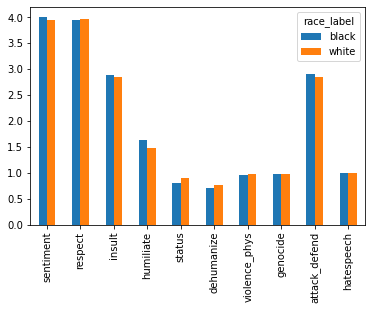

In [126]:
#chose comment from black_v_white comments
mean_item_by_race(df_race_distribution, 20001);